In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("../src")

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f"Shape of DBTL cycle 1: {df_A.shape} and DBTL cycle 2: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds


bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of DBTL cycle 1: (27, 10) and DBTL cycle 2: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


# Model selection (NCV)

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Uncomment to run model selection
# modelSelection(X_train, y_train)

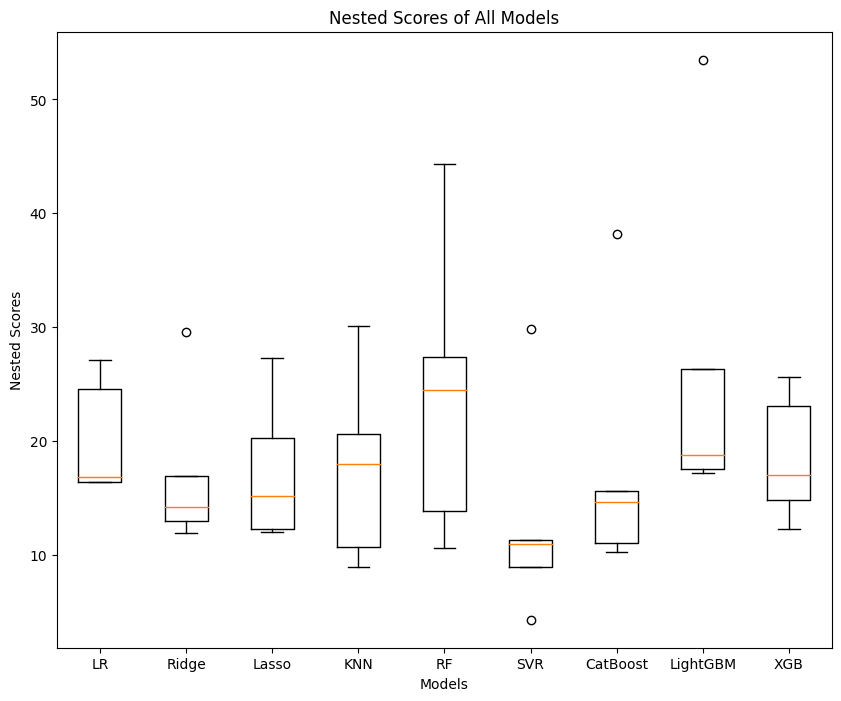

# ML training (Optuna)

In [3]:
import optuna
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score


def objective(trial):
    # Define the hyperparameters to optimize
    C = trial.suggest_loguniform("C", 0.01, 100)
    epsilon = trial.suggest_loguniform("epsilon", 0.01, 1)
    gamma = trial.suggest_loguniform("gamma", 0.001, 1)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    degree = trial.suggest_int("degree", 2, 5)

    # Create the SVR model with the hyperparameters
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel, degree=degree)
    scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
    )
    return -scores.mean()


# Create the study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
final_model = SVR(**best_params)
final_model.fit(X_train, y_train)

[I 2024-02-15 13:58:56,439] A new study created in memory with name: no-name-4a8e3f81-71f2-4c41-b085-28ed5aefe2fe
[I 2024-02-15 13:58:56,468] Trial 0 finished with value: 15.772155528571483 and parameters: {'C': 43.32556878257419, 'epsilon': 0.3673142415826091, 'gamma': 0.011017245463125066, 'kernel': 'linear', 'degree': 3}. Best is trial 0 with value: 15.772155528571483.
[I 2024-02-15 13:58:56,491] Trial 1 finished with value: 16.71275509503178 and parameters: {'C': 44.350007711440945, 'epsilon': 0.5173789984238747, 'gamma': 0.0037842012531707353, 'kernel': 'rbf', 'degree': 5}. Best is trial 0 with value: 15.772155528571483.
[I 2024-02-15 13:58:56,514] Trial 2 finished with value: 22.032854753656245 and parameters: {'C': 0.023694256052566195, 'epsilon': 0.9147616212598585, 'gamma': 0.014345512912114895, 'kernel': 'linear', 'degree': 5}. Best is trial 0 with value: 15.772155528571483.
[I 2024-02-15 13:58:56,536] Trial 3 finished with value: 22.242815026425166 and parameters: {'C': 0.07

SVR(C=4.249837278910897, degree=2, epsilon=0.1393509564876511,
    gamma=0.003687477221408632, kernel='linear')

# Model evaluation (Bootstrap)

In [4]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values


mae_values = bootstrap(X_train, y_train, SVR(**final_model.get_params()))
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

100%|██████████| 100/100 [00:00<00:00, 299.47it/s]

Bootstraped Mean(MAE) = 15.116488113532798


SVR(C=4.249837278910897, degree=2, epsilon=0.1393509564876511,
    gamma=0.003687477221408632, kernel='linear')

# Explainable AI 

  0%|          | 0/27 [00:00<?, ?it/s]

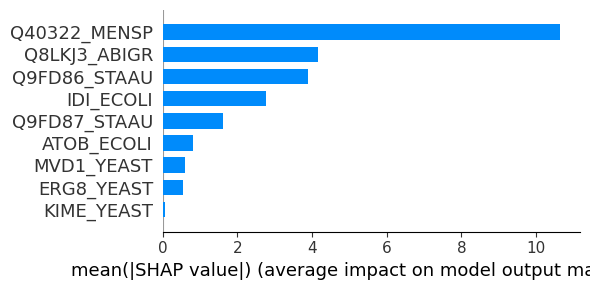

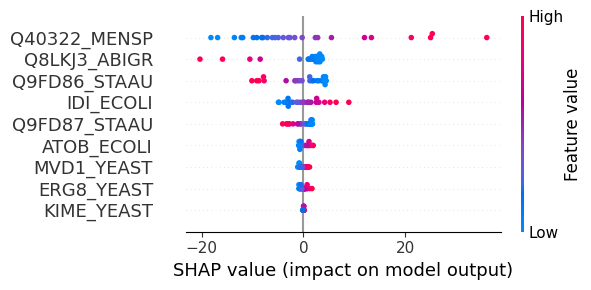

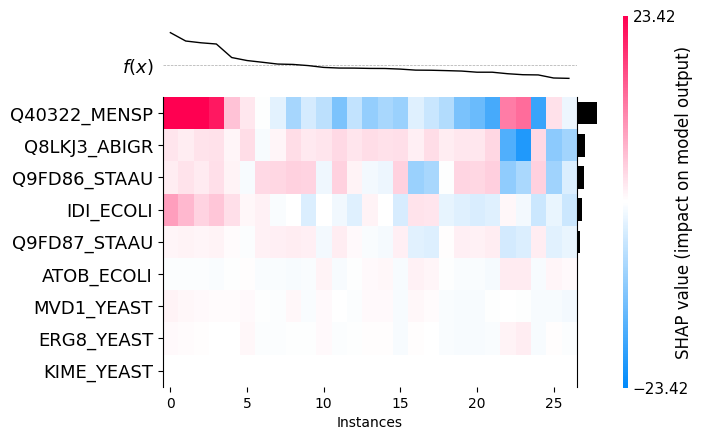

In [5]:
import shap
import matplotlib.pyplot as plt


def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.KernelExplainer(final_model.predict, df_A[INPUT_VARS])
shap_values = shap_explainer(df_A[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = final_model.predict(df_A[INPUT_VARS])
shap_df["true"] = df_A[RESPONSE_VARS].values.ravel()
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

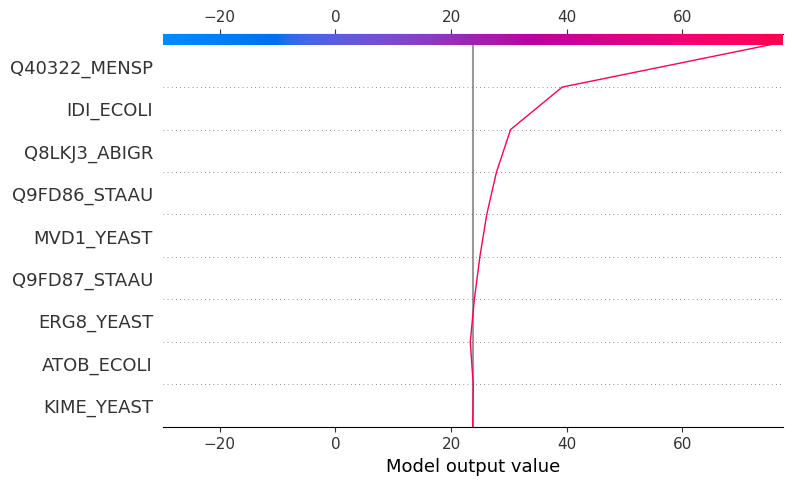

pred    75.307473
true    75.392610
Name: 0, dtype: float64


In [6]:
idx=0
shap.decision_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[idx].values, 
                   INPUT_VARS)

print(shap_df[['pred', 'true']].iloc[idx])

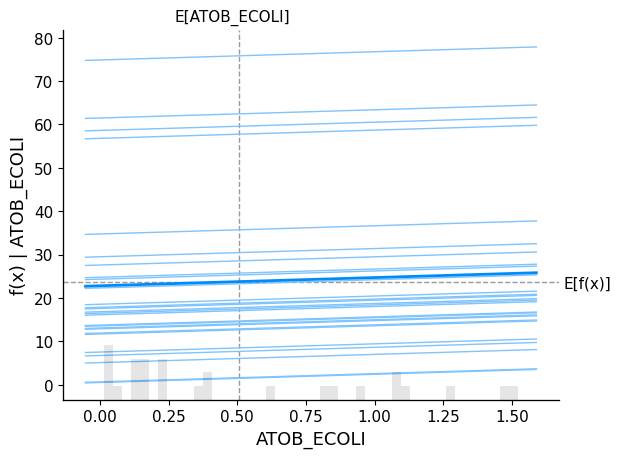

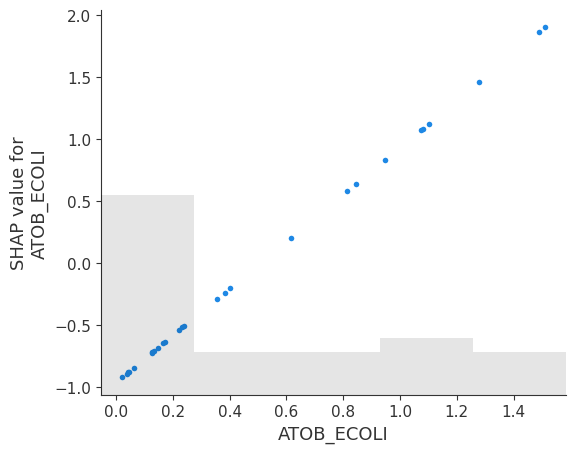

In [7]:
feature = "ATOB_ECOLI"
pdplot(df_A[INPUT_VARS], feature, final_model, ice=True)
shap_scatter(feature)

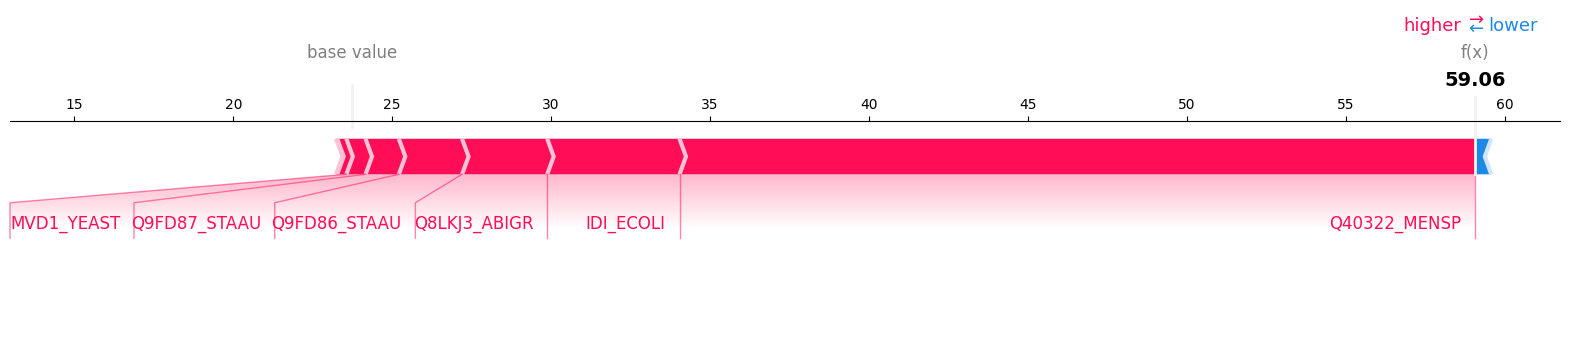

In [8]:
shap.force_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[2].values, 
                   features=INPUT_VARS,
                   matplotlib=True, show=True)

# Lime

In [9]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Limonene"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Limonene", ascending=False, inplace=True)
# Drop rows with Limonene < 0
sample_df = sample_df[sample_df["Limonene"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Limonene"]

Intercept 14.867737929587475
Prediction_local [73.03570154]
Right: 81.02808072663657


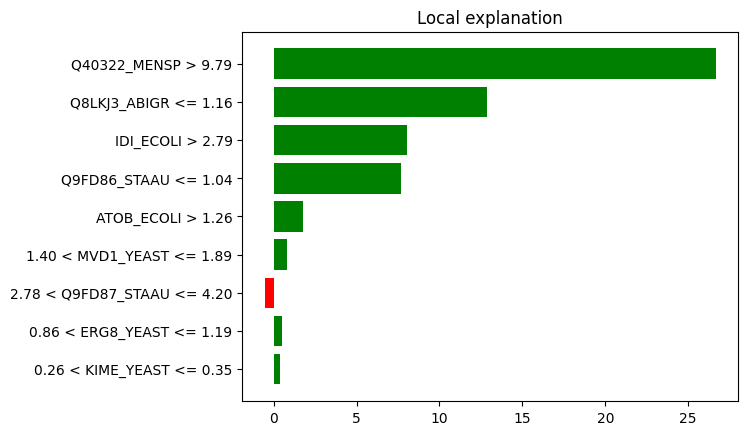

In [27]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_synth.values, feature_names=INPUT_VARS, class_names='Limonene', 
                                                   verbose=True, mode='regression')
i = 1
exp = explainer.explain_instance(X_synth.values[i], final_model.predict)
exp.show_in_notebook(show_table=True, show_all=True)
exp.as_list()
exp.as_pyplot_figure();

# Sampling

In [11]:
# original bounds
bounds

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


Create new `sampling bounds`, to generate/recommend new strain designs.

In [29]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 9.79
sampling_bounds["Q40322_MENSP"].loc["max"] = bounds["Q40322_MENSP"].loc["max"]

sampling_bounds["ATOB_ECOLI"].loc["min"] = 1.26 # bounds["ATOB_ECOLI"].loc["min"]
sampling_bounds["ATOB_ECOLI"].loc["max"] = bounds["ATOB_ECOLI"].loc["max"]

sampling_bounds["Q9FD87_STAAU"].loc["min"] = bounds["Q9FD87_STAAU"].loc["min"]
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 1.04

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = bounds["Q8LKJ3_ABIGR"].loc["min"]
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 1.16

sampling_bounds["Q9FD86_STAAU"].loc["min"] = bounds["Q9FD86_STAAU"].loc["min"]
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 1.40

sampling_bounds["MVD1_YEAST"].loc["min"] = 1.89
sampling_bounds["MVD1_YEAST"].loc["max"] = bounds["MVD1_YEAST"].loc["max"]

sampling_bounds["ERG8_YEAST"].loc["min"] = 1.19
sampling_bounds["ERG8_YEAST"].loc["max"] = bounds["ERG8_YEAST"].loc["max"]

sampling_bounds["KIME_YEAST"].loc["min"] = 0.26
sampling_bounds["KIME_YEAST"].loc["max"] = 0.35 # bounds["KIME_YEAST"].loc["max"]

sampling_bounds["IDI_ECOLI"].loc["min"] = 2.79
sampling_bounds["IDI_ECOLI"].loc["max"] = bounds["IDI_ECOLI"].loc["max"]

# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
557,1.355948,1.431803,3.395895,0.341763,2.200693,11.974495,0.117517,0.164205,0.763300,87.096942
290,1.500278,1.324400,3.419975,0.305981,2.024626,12.188433,0.382341,0.134797,0.736368,86.897335
578,1.367433,1.462103,3.280539,0.274560,2.236810,11.958931,0.188082,0.079627,0.868786,86.270734
469,1.613190,1.326528,3.380909,0.326585,1.953592,12.151587,0.063519,0.797419,0.538932,86.104445
833,1.627260,1.314621,3.363241,0.268552,1.997913,11.987665,0.231758,0.430026,0.126286,86.068847
783,1.547678,1.428528,3.146972,0.321255,1.984149,12.040264,0.187610,0.324942,0.380003,85.583000
594,1.604744,1.216317,2.982918,0.307587,1.909890,12.181489,0.079107,0.373550,0.229385,85.554813
669,1.289707,1.227498,3.425584,0.298241,2.162205,12.123380,0.228008,0.747999,0.045226,85.500497
910,1.294079,1.283312,3.389200,0.273104,2.310215,11.997640,0.179468,0.422435,0.827383,85.487253
508,1.414830,1.500606,3.053277,0.328791,2.211502,12.183971,0.247526,0.379020,0.463636,85.427450


# Counterfactuals (`DiCE`)

In [30]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=10,
    desired_range=[80, 85],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Query instance (original outcome : 27.8851375579834)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.1654,0.4407,1.8527,0.2555,1.129,4.5317,0.8922,0.2786,0.3756,27.885138



Diverse Counterfactual set (new outcome: [80, 85])


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,1.26,1.19,2.79,0.26,1.89,11.8367,0.3879,0.028,0.4914,81.1431272240822
0,1.26,1.19,2.79,0.26,1.89,12.0534,0.4335,0.0729,0.0429,82.42826053592148
0,1.26,1.19,2.79,0.26,1.89,12.0534,0.4335,0.028,0.0429,82.59476560414507
0,1.26,1.19,2.79,0.26,1.89,12.0592,0.3879,0.028,0.0429,82.8723571126043
0,1.26,1.19,3.0725,0.26,1.89,12.0534,0.4335,0.3916,0.0429,82.83306991320754
0,1.26,1.19,3.0725,0.26,1.89,12.0534,0.4335,0.028,0.0429,84.18142721401153
0,1.26,1.1901,3.0725,0.26,1.89,12.1099,0.4335,0.028,0.0429,84.48935071098384
0,1.26,1.19,2.79,0.2601,1.89,11.7346,0.2564,0.028,0.0429,81.81400966687065
0,1.26,1.19,2.79,0.2601,1.8962,11.7346,0.2564,0.028,0.0429,81.82219905960008
0,1.26,1.19,2.79,0.26,1.89,12.1099,0.2564,0.028,0.0429,83.8578963627694


# PCA

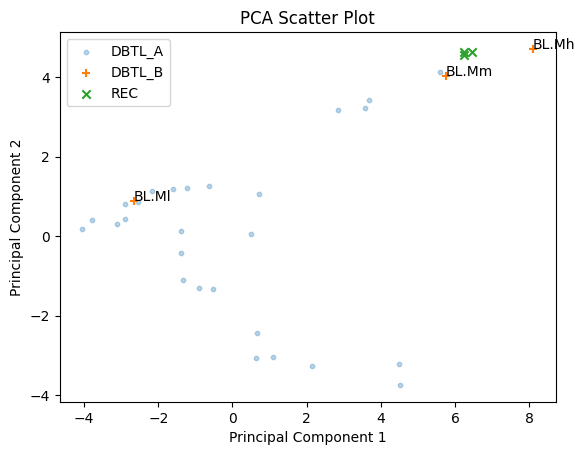

BL.Mh    127.99494
BL.Mm    119.81367
BL.Ml      6.72018
Name: Limonene, dtype: float64


In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(sample_df[INPUT_VARS][:3])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker="+")
for i, txt in enumerate(DBTL_B):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker="x")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(df_B["Limonene"].sort_values(ascending=False))